# 🚢 Titanic Survival Predictor - Machine Learning Model

## Project Overview
This notebook builds a comprehensive machine learning model to predict Titanic passenger survival. The model can predict whether a person would have survived the Titanic disaster based on their personal characteristics.

**Key Features:**
- Multiple ML algorithms comparison
- Advanced feature engineering
- Interactive prediction interface
- Model interpretation and insights
- Real-time survival probability

**Use Case:** Input your personal information (age, gender, class, etc.) and discover if you would have survived the Titanic!

---

## 1. Setup and Data Loading

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

# Interactive widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("Note: ipywidgets not available. Interactive features will be limited.")

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🚀 All libraries imported successfully!")
print(f"📊 Widgets available: {WIDGETS_AVAILABLE}")

🚀 All libraries imported successfully!
📊 Widgets available: True


In [2]:
# Load the Titanic dataset
df = pd.read_csv('Titanic-Dataset.csv')

print("🚢 Titanic Dataset Loaded Successfully!")
print(f"Dataset Shape: {df.shape}")
print(f"Survival Rate: {df['Survived'].mean():.1%}")

# Display basic information
print("\n=== Dataset Overview ===")
print(df.info())
print("\n=== First 5 Records ===")
print(df.head())

🚢 Titanic Dataset Loaded Successfully!
Dataset Shape: (891, 12)
Survival Rate: 38.4%

=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

=== First 5 Records ===
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       

---
## 2. Data Preprocessing and Feature Engineering

In [3]:
def create_features(data):
    """
    Comprehensive feature engineering function
    """
    df = data.copy()
    
    # 1. Family Size Features
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    df['Is_Alone'] = (df['Family_Size'] == 1).astype(int)
    df['Family_Category'] = pd.cut(df['Family_Size'], 
                                   bins=[0, 1, 4, 20], 
                                   labels=['Alone', 'Small', 'Large'])
    
    # 2. Title Extraction and Grouping (Fixed regex)
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    
    # Group rare titles
    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss', 
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Rare',
        'Rev': 'Rare',
        'Col': 'Rare',
        'Major': 'Rare',
        'Mlle': 'Miss',
        'Countess': 'Rare',
        'Ms': 'Miss',
        'Lady': 'Rare',
        'Jonkheer': 'Rare',
        'Don': 'Rare',
        'Dona': 'Rare',
        'Mme': 'Mrs',
        'Capt': 'Rare',
        'Sir': 'Rare'
    }
    df['Title_Grouped'] = df['Title'].map(title_mapping)
    # Fix: Use proper assignment instead of inplace
    df['Title_Grouped'] = df['Title_Grouped'].fillna('Rare')
    
    # 3. Age Groups (will be updated after missing value handling)
    df['Age_Group'] = pd.cut(df['Age'], 
                            bins=[0, 12, 18, 30, 50, 100], 
                            labels=['Child', 'Teen', 'Young_Adult', 'Adult', 'Senior'])
    
    # 4. Fare Groups (will be updated after missing value handling)
    df['Fare_Group'] = pd.cut(df['Fare'], 
                             bins=[0, 8, 15, 31, 100, 1000], 
                             labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
    
    # 5. Deck Information (Fixed to handle NaN values)
    df['Has_Cabin'] = df['Cabin'].notna().astype(int)
    # Only extract deck letter for non-null cabin values
    df['Deck'] = df['Cabin'].astype(str).str[0]
    # Replace 'n' (from 'nan') with 'Unknown' for missing cabins
    df['Deck'] = df['Deck'].replace('n', 'Unknown')
    
    # 6. Ticket Features (Fixed to handle string conversion properly)
    df['Ticket_Length'] = df['Ticket'].astype(str).str.len()
    df['Ticket_Prefix'] = df['Ticket'].astype(str).str.extract('([A-Za-z]+)')
    df['Has_Ticket_Prefix'] = df['Ticket_Prefix'].notna().astype(int)
    
    # 7. Economic Status Indicators (fixed quantile call)
    df['Fare_Per_Person'] = df['Fare'] / df['Family_Size']
    # Fix: Remove skipna parameter which doesn't exist in older pandas versions
    fare_75th = df['Fare'].quantile(0.75)
    df['High_Fare'] = (df['Fare'] > fare_75th).astype(int)
    
    return df

# Apply feature engineering
df_features = create_features(df)

print("✨ Feature Engineering Complete!")
print(f"Original features: {df.shape[1]}")
print(f"Enhanced features: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df.shape[1]}")

# Display new features
new_features = ['Family_Size', 'Is_Alone', 'Title_Grouped', 'Age_Group', 
                'Fare_Group', 'Has_Cabin', 'Fare_Per_Person']
print("\n=== Sample of Enhanced Features ===")
print(df_features[new_features].head())

✨ Feature Engineering Complete!
Original features: 12
Enhanced features: 26
New features added: 14

=== Sample of Enhanced Features ===
   Family_Size  Is_Alone Title_Grouped    Age_Group Fare_Group  Has_Cabin  \
0            2         0            Mr  Young_Adult   Very_Low          0   
1            2         0           Mrs        Adult       High          1   
2            1         1          Miss  Young_Adult   Very_Low          0   
3            2         0           Mrs        Adult       High          1   
4            1         1            Mr        Adult        Low          0   

   Fare_Per_Person  
0          3.62500  
1         35.64165  
2          7.92500  
3         26.55000  
4          8.05000  


In [4]:
def preprocess_data(data):
    """
    Complete data preprocessing pipeline
    """
    df = data.copy()
    
    # Handle missing values intelligently
    
    # Age: Fill with median by Title and Pclass
    age_medians = df.groupby(['Title_Grouped', 'Pclass'])['Age'].median()
    for (title, pclass), median_age in age_medians.items():
        mask = (df['Title_Grouped'] == title) & (df['Pclass'] == pclass) & df['Age'].isna()
        df.loc[mask, 'Age'] = median_age
    
    # Fill remaining missing ages with overall median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # Embarked: Fill with mode
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # Fare: Fill with median by Pclass
    fare_medians = df.groupby('Pclass')['Fare'].median()
    for pclass, median_fare in fare_medians.items():
        mask = (df['Pclass'] == pclass) & df['Fare'].isna()
        df.loc[mask, 'Fare'] = median_fare
    
    # Update categorical features that depend on filled values
    df['Age_Group'] = pd.cut(df['Age'], 
                            bins=[0, 12, 18, 30, 50, 100], 
                            labels=['Child', 'Teen', 'Young_Adult', 'Adult', 'Senior'])
    
    df['Fare_Group'] = pd.cut(df['Fare'], 
                             bins=[0, 8, 15, 31, 100, 1000], 
                             labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
    
    df['Fare_Per_Person'] = df['Fare'] / df['Family_Size']
    
    # Select and encode features for ML
    feature_columns = [
        # Original features
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
        
        # Engineered features
        'Family_Size', 'Is_Alone', 'Title_Grouped', 'Age_Group', 
        'Fare_Group', 'Has_Cabin', 'Fare_Per_Person', 'High_Fare'
    ]
    
    # Create feature matrix
    X = df[feature_columns].copy()
    y = df['Survived'].copy()
    
    # Encode categorical variables
    categorical_features = ['Sex', 'Embarked', 'Title_Grouped', 'Age_Group', 'Fare_Group']
    
    # Use LabelEncoder for categorical features
    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        X.loc[:, feature] = le.fit_transform(X[feature].astype(str))
        label_encoders[feature] = le
    
    return X, y, label_encoders, feature_columns

# Preprocess the data
X, y, label_encoders, feature_columns = preprocess_data(df_features)

print("🔧 Data Preprocessing Complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

print("\n=== Final Feature Set ===")
for i, feature in enumerate(feature_columns):
    print(f"{i+1:2d}. {feature}")

🔧 Data Preprocessing Complete!
Feature matrix shape: (891, 15)
Target variable shape: (891,)
Missing values in X: 0
Missing values in y: 0

=== Final Feature Set ===
 1. Pclass
 2. Sex
 3. Age
 4. SibSp
 5. Parch
 6. Fare
 7. Embarked
 8. Family_Size
 9. Is_Alone
10. Title_Grouped
11. Age_Group
12. Fare_Group
13. Has_Cabin
14. Fare_Per_Person
15. High_Fare


---
## 3. Model Building and Comparison

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training survival rate: {y_train.mean():.1%}")
print(f"Test survival rate: {y_test.mean():.1%}")

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Age', 'Fare', 'Family_Size', 'Fare_Per_Person']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\n📏 Feature scaling complete!")

Training set: (712, 15)
Test set: (179, 15)
Training survival rate: 38.3%
Test survival rate: 38.5%

📏 Feature scaling complete!


In [6]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate models
model_results = {}
trained_models = {}

print("🤖 Training Multiple Models...")
print("=" * 50)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Use scaled data for SVM and Logistic Regression
    if name in ['Support Vector Machine', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"✅ {name}:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV Score: {cv_mean:.4f} (+/- {cv_std*2:.4f})")

print("\n" + "=" * 50)
print("🏆 Model Training Complete!")

🤖 Training Multiple Models...

🔄 Training Logistic Regression...
✅ Logistic Regression:
   Accuracy: 0.8045
   ROC-AUC: 0.8559
   CV Score: 0.7950 (+/- 0.0585)

🔄 Training Random Forest...
✅ Random Forest:
   Accuracy: 0.8156
   ROC-AUC: 0.8437
   CV Score: 0.7978 (+/- 0.0558)

🔄 Training Gradient Boosting...
✅ Gradient Boosting:
   Accuracy: 0.7989
   ROC-AUC: 0.8283
   CV Score: 0.8344 (+/- 0.0745)

🔄 Training Support Vector Machine...
✅ Support Vector Machine:
   Accuracy: 0.8324
   ROC-AUC: 0.8601
   CV Score: 0.8189 (+/- 0.0381)

🔄 Training Naive Bayes...
✅ Naive Bayes:
   Accuracy: 0.7039
   ROC-AUC: 0.7980
   CV Score: 0.7626 (+/- 0.0643)

🏆 Model Training Complete!


📊 Model Performance Comparison
                        accuracy   roc_auc   cv_mean    cv_std
Logistic Regression     0.804469  0.855863  0.795036  0.029239
Random Forest           0.815642  0.843742  0.797843  0.027886
Gradient Boosting       0.798883  0.828327  0.834394  0.037234
Support Vector Machine  0.832402  0.860079  0.818871  0.019033
Naive Bayes             0.703911  0.798024  0.762622  0.032154

🥇 Best Model: Gradient Boosting
   CV Accuracy: 0.8344
   Test Accuracy: 0.7989
   ROC-AUC: 0.8283


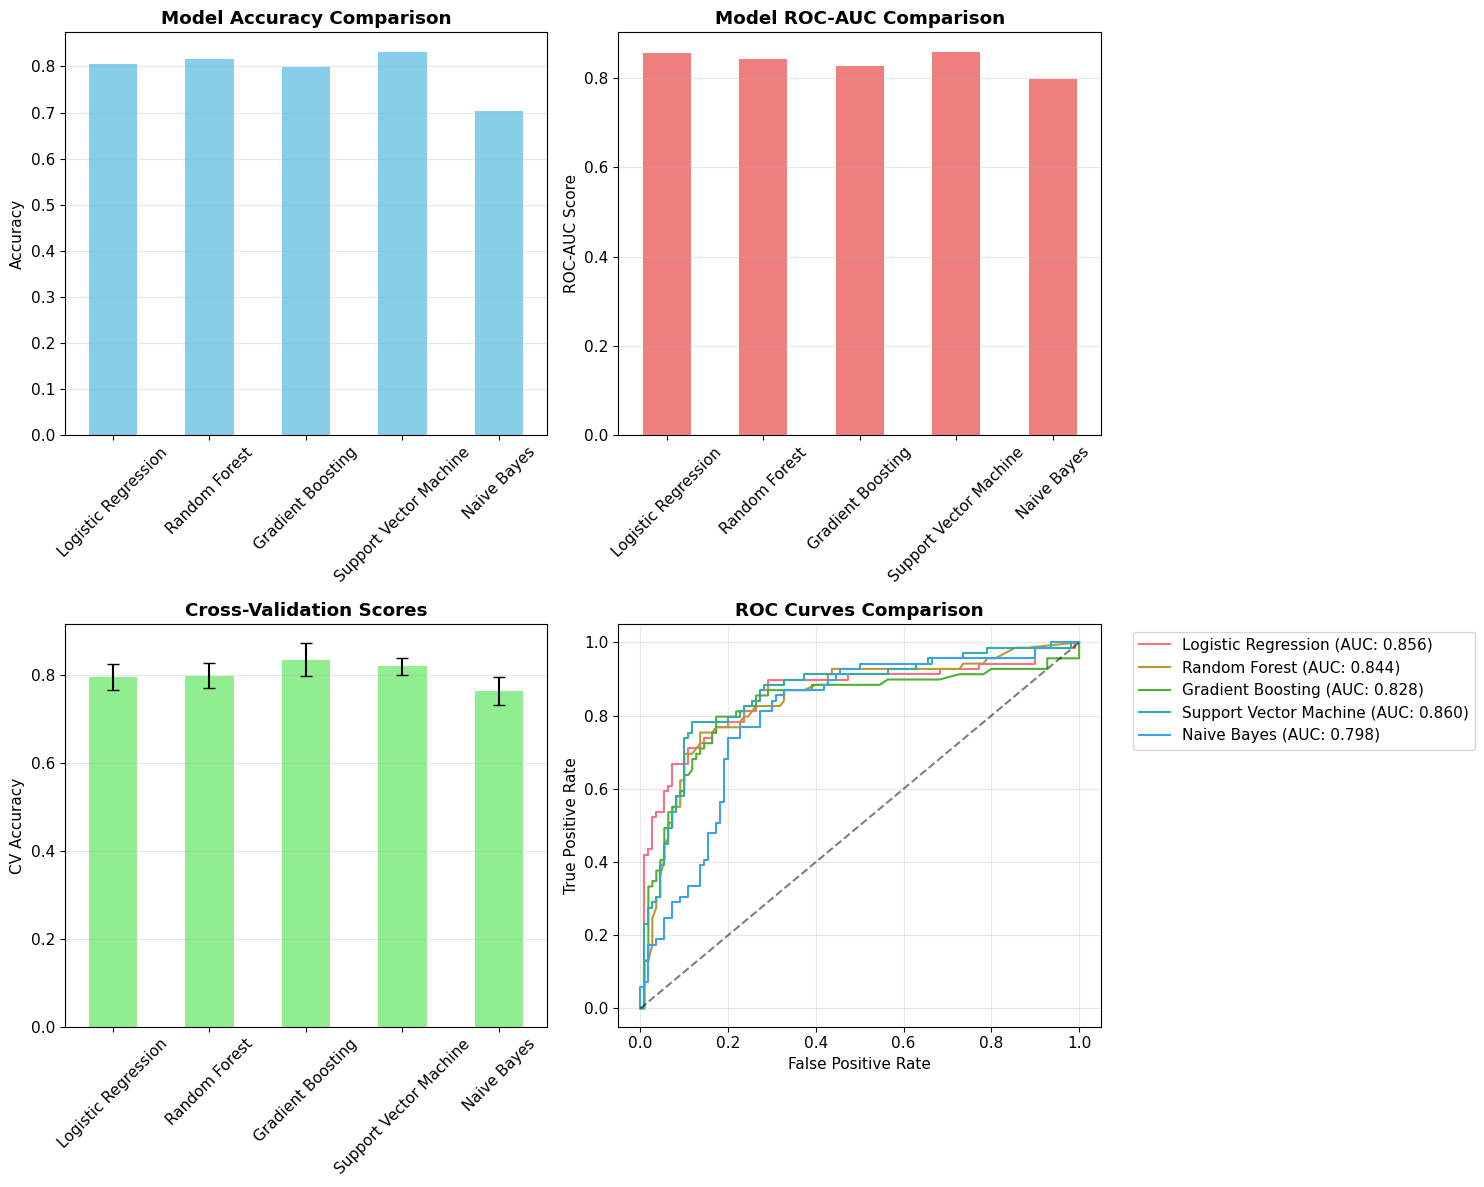

In [7]:
# Create comprehensive model comparison
results_df = pd.DataFrame(model_results).T
results_df = results_df[['accuracy', 'roc_auc', 'cv_mean', 'cv_std']]
results_df = results_df.round(4)

print("📊 Model Performance Comparison")
print("=" * 50)
print(results_df)

# Find best model
best_model_name = results_df['cv_mean'].idxmax()
best_model = trained_models[best_model_name]

print(f"\n🥇 Best Model: {best_model_name}")
print(f"   CV Accuracy: {results_df.loc[best_model_name, 'cv_mean']:.4f}")
print(f"   Test Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
results_df['accuracy'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# ROC-AUC comparison
results_df['roc_auc'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Model ROC-AUC Comparison', fontweight='bold')
axes[0,1].set_ylabel('ROC-AUC Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# Cross-validation scores with error bars
results_df['cv_mean'].plot(kind='bar', ax=axes[1,0], 
                          yerr=results_df['cv_std'], 
                          capsize=4, color='lightgreen')
axes[1,0].set_title('Cross-Validation Scores', fontweight='bold')
axes[1,0].set_ylabel('CV Accuracy')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# ROC Curves
for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    axes[1,1].plot(fpr, tpr, label=f"{name} (AUC: {results['roc_auc']:.3f})")

axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curves Comparison', fontweight='bold')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Model Optimization and Feature Importance

In [8]:
# Hyperparameter tuning for the best model
print(f"🔧 Optimizing {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    base_model = GradientBoostingClassifier(random_state=42)
    
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    
else:
    # For other models, use simpler grid
    param_grid = {}
    base_model = best_model

if param_grid:
    # Perform grid search
    grid_search = GridSearchCV(
        base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1
    )
    
    # Use appropriate data based on model type
    if best_model_name in ['Support Vector Machine', 'Logistic Regression']:
        grid_search.fit(X_train_scaled, y_train)
        optimized_model = grid_search.best_estimator_
        final_predictions = optimized_model.predict(X_test_scaled)
        final_probabilities = optimized_model.predict_proba(X_test_scaled)[:, 1]
    else:
        grid_search.fit(X_train, y_train)
        optimized_model = grid_search.best_estimator_
        final_predictions = optimized_model.predict(X_test)
        final_probabilities = optimized_model.predict_proba(X_test)[:, 1]
    
    final_accuracy = accuracy_score(y_test, final_predictions)
    final_roc_auc = roc_auc_score(y_test, final_probabilities)
    
    print(f"\n✅ Optimization Complete!")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Optimized CV score: {grid_search.best_score_:.4f}")
    print(f"Optimized test accuracy: {final_accuracy:.4f}")
    print(f"Optimized ROC-AUC: {final_roc_auc:.4f}")
    
else:
    optimized_model = best_model
    final_predictions = model_results[best_model_name]['predictions']
    final_probabilities = model_results[best_model_name]['probabilities']
    final_accuracy = model_results[best_model_name]['accuracy']
    final_roc_auc = model_results[best_model_name]['roc_auc']
    
    print(f"\n✅ Using best model without additional tuning")
    print(f"Final test accuracy: {final_accuracy:.4f}")
    print(f"Final ROC-AUC: {final_roc_auc:.4f}")

🔧 Optimizing Gradient Boosting...

✅ Optimization Complete!
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Optimized CV score: 0.8344
Optimized test accuracy: 0.7989
Optimized ROC-AUC: 0.8283



🎯 Feature Importance Analysis
 1. Sex                  0.4353
 2. Age                  0.1340
 3. Fare_Per_Person      0.1224
 4. Pclass               0.1102
 5. Fare                 0.0767
 6. Family_Size          0.0334
 7. Has_Cabin            0.0290
 8. Embarked             0.0184
 9. Title_Grouped        0.0163
10. SibSp                0.0106


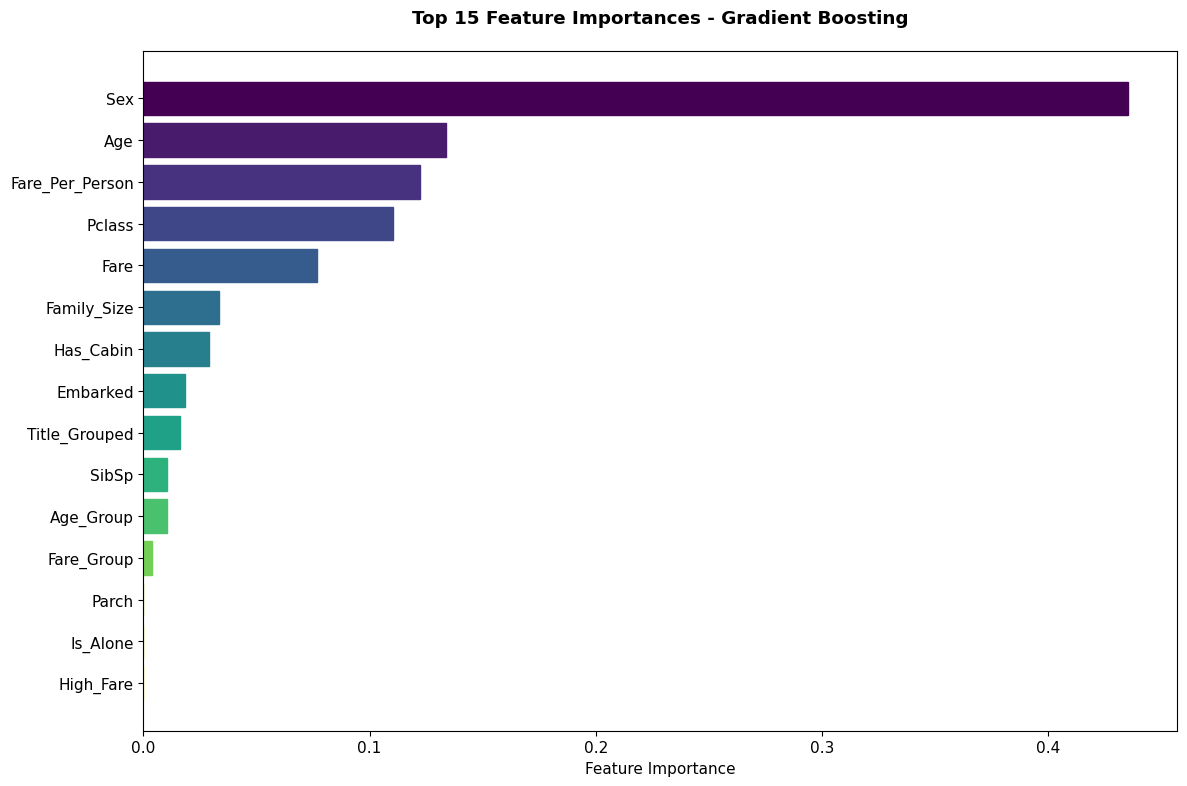

In [9]:
# Feature importance analysis
if hasattr(optimized_model, 'feature_importances_'):
    # Tree-based models
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': optimized_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
elif hasattr(optimized_model, 'coef_'):
    # Linear models
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': np.abs(optimized_model.coef_[0])
    }).sort_values('importance', ascending=False)
    
else:
    feature_importance = None

if feature_importance is not None:
    print("\n🎯 Feature Importance Analysis")
    print("=" * 40)
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<20} {row['importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    
    # Color bars by importance
    colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    plt.tight_layout()
    plt.show()
    
    # Store for prediction function
    top_features_list = feature_importance.head(10)['feature'].tolist()
else:
    top_features_list = feature_columns[:10]

---
## 5. Model Evaluation and Insights

📈 Comprehensive Model Evaluation

🎯 Final Model Performance (Gradient Boosting):
   Accuracy: 0.7989
   ROC-AUC: 0.8283
   Precision: 0.7705
   Recall: 0.6812
   Specificity: 0.8727

📊 Confusion Matrix:
   True Negatives:   96
   False Positives:  14
   False Negatives:  22
   True Positives:   47


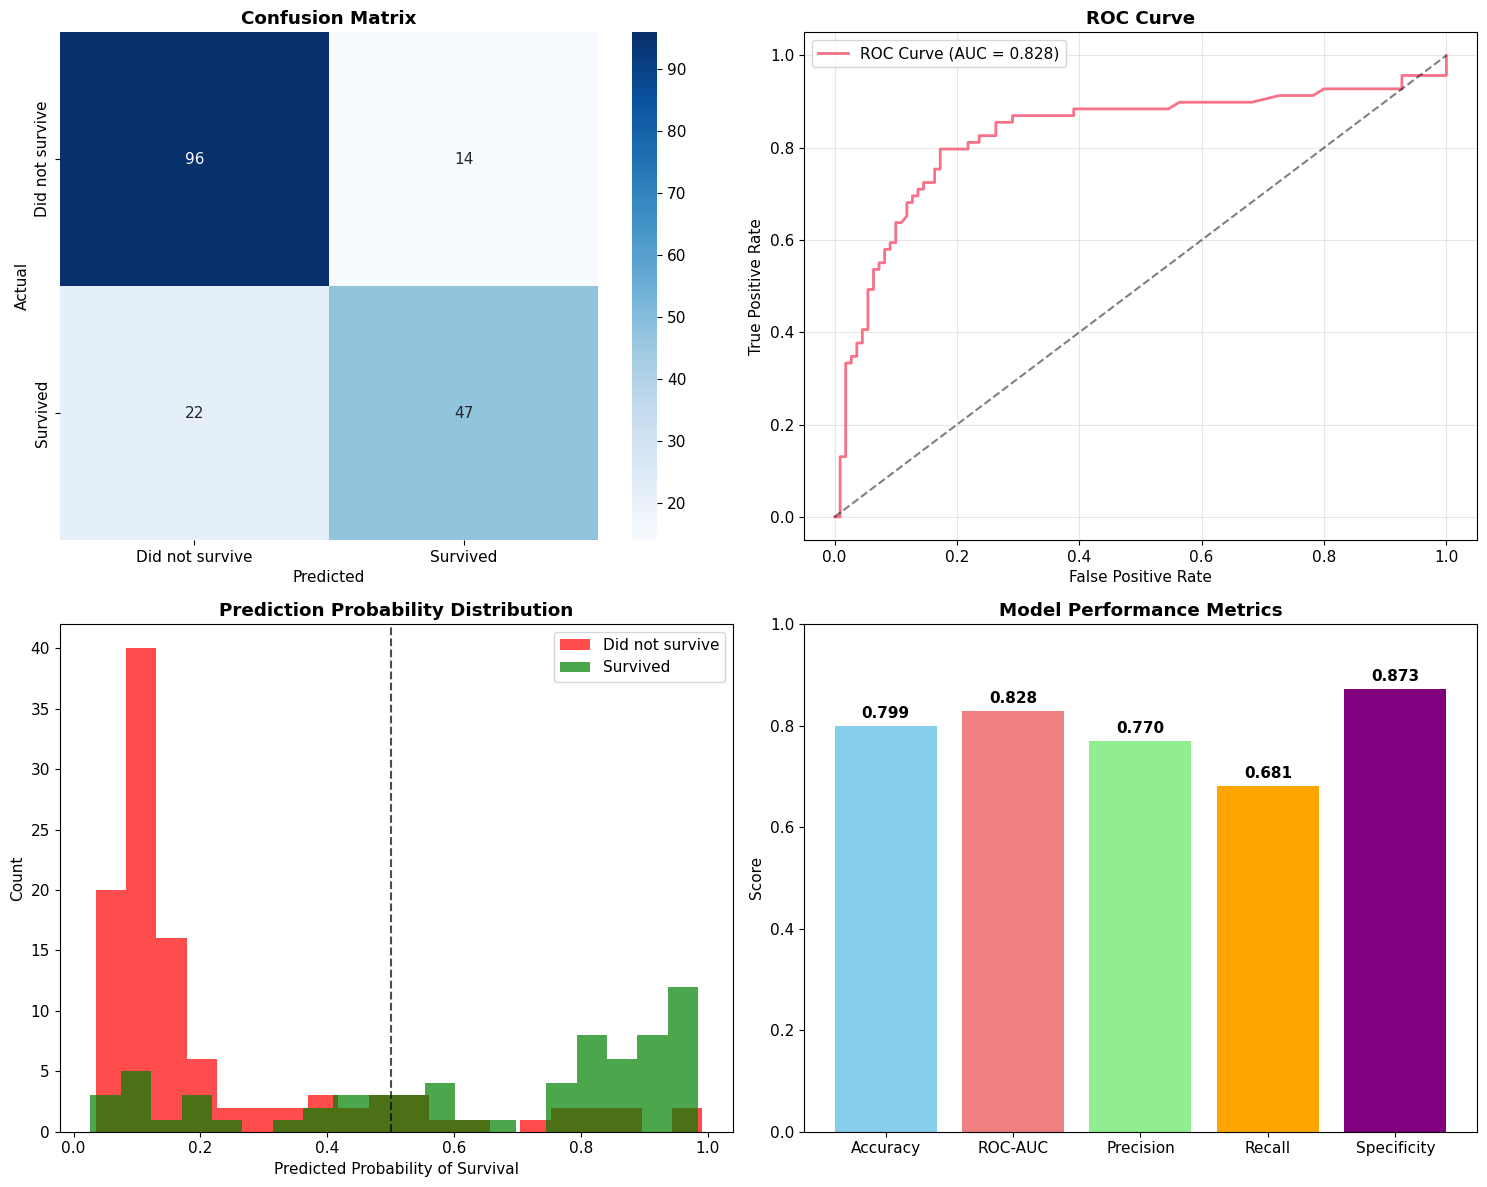


✅ Model evaluation complete!


In [10]:
# Detailed model evaluation
print("📈 Comprehensive Model Evaluation")
print("=" * 50)

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
tn, fp, fn, tp = cm.ravel()

print(f"\n🎯 Final Model Performance ({best_model_name}):")
print(f"   Accuracy: {final_accuracy:.4f}")
print(f"   ROC-AUC: {final_roc_auc:.4f}")
print(f"   Precision: {tp/(tp+fp):.4f}")
print(f"   Recall: {tp/(tp+fn):.4f}")
print(f"   Specificity: {tn/(tn+fp):.4f}")

print(f"\n📊 Confusion Matrix:")
print(f"   True Negatives:  {tn:3d}")
print(f"   False Positives: {fp:3d}")
print(f"   False Negatives: {fn:3d}")
print(f"   True Positives:  {tp:3d}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontweight='bold')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xticklabels(['Did not survive', 'Survived'])
axes[0,0].set_yticklabels(['Did not survive', 'Survived'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, final_probabilities)
axes[0,1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Prediction Probability Distribution
survived_probs = final_probabilities[y_test == 1]
died_probs = final_probabilities[y_test == 0]

axes[1,0].hist(died_probs, bins=20, alpha=0.7, label='Did not survive', color='red')
axes[1,0].hist(survived_probs, bins=20, alpha=0.7, label='Survived', color='green')
axes[1,0].set_xlabel('Predicted Probability of Survival')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Prediction Probability Distribution', fontweight='bold')
axes[1,0].legend()
axes[1,0].axvline(0.5, color='black', linestyle='--', alpha=0.7)

# Model Performance Summary
metrics = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'Specificity']
values = [final_accuracy, final_roc_auc, tp/(tp+fp), tp/(tp+fn), tn/(tn+fp)]

bars = axes[1,1].bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple'])
axes[1,1].set_title('Model Performance Metrics', fontweight='bold')
axes[1,1].set_ylabel('Score')
axes[1,1].set_ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Model evaluation complete!")

def predict_survival(pclass, sex, age, sibsp, parch, fare, embarked, 
                    model=None, encoders=None, scaler=None, features=None):
    """
    Predict survival probability for a given passenger profile
    """
    # Use global variables if not provided
    if model is None:
        try:
            model = optimized_model
        except NameError:
            raise ValueError("Model not trained yet. Please run the training cells first.")
    
    if encoders is None:
        try:
            encoders = label_encoders
        except NameError:
            raise ValueError("Encoders not available. Please run the preprocessing cells first.")
    
    # Create input dataframe with proper structure matching original data
    input_data = pd.DataFrame({
        'PassengerId': [999],        # Dummy ID
        'Survived': [0],             # Dummy target
        'Pclass': [pclass],
        'Name': ['User, Test'],      # Dummy name for title extraction
        'Sex': [sex],
        'Age': [age],
        'SibSp': [sibsp],
        'Parch': [parch],
        'Ticket': ['TEST123'],       # Dummy ticket
        'Fare': [fare],
        'Cabin': [np.nan],           # No cabin info
        'Embarked': [embarked]
    })
    
    # Apply feature engineering
    input_features = create_features(input_data)
    
    # Handle title for user input (override the dummy title extraction)
    if sex.lower() == 'male':
        if age < 18:
            input_features.loc[0, 'Title_Grouped'] = 'Master'
        else:
            input_features.loc[0, 'Title_Grouped'] = 'Mr'
    else:
        if age < 18:
            input_features.loc[0, 'Title_Grouped'] = 'Miss'
        else:
            # For simplicity, use Miss for adult females in this demo
            input_features.loc[0, 'Title_Grouped'] = 'Miss'
    
    # Apply preprocessing to get the feature matrix
    X_input, _, _, _ = preprocess_data(input_features)
    X_input = X_input.iloc[0:1]  # Keep only first row
    
    # Make prediction
    try:
        if hasattr(model, 'predict_proba'):
            # Check if we need to use scaled features
            if 'best_model_name' in globals() and best_model_name in ['Support Vector Machine', 'Logistic Regression']:
                if 'scaler' in globals() and scaler is not None:
                    # Use scaled data for SVM and Logistic Regression
                    numerical_features = ['Age', 'Fare', 'Family_Size', 'Fare_Per_Person']
                    X_input_scaled = X_input.copy()
                    X_input_scaled[numerical_features] = scaler.transform(X_input[numerical_features])
                    survival_probability = model.predict_proba(X_input_scaled)[0, 1]
                    survival_prediction = model.predict(X_input_scaled)[0]
                else:
                    survival_probability = model.predict_proba(X_input)[0, 1]
                    survival_prediction = model.predict(X_input)[0]
            else:
                survival_probability = model.predict_proba(X_input)[0, 1]
                survival_prediction = model.predict(X_input)[0]
        else:
            # For models without probability prediction
            survival_prediction = model.predict(X_input)[0]
            survival_probability = float(survival_prediction)
    except Exception as e:
        raise ValueError(f"Error during prediction: {e}")
    
    return survival_probability, survival_prediction

# Test the prediction function
try:
    test_prob, test_pred = predict_survival(
        pclass=3, sex='male', age=22, sibsp=1, parch=0, fare=7.25, embarked='S'
    )
    
    print("🧪 Testing Prediction Function:")
    print(f"Test case (similar to first passenger):")
    print(f"  Survival Probability: {test_prob:.2%}")
    print(f"  Prediction: {'Survived' if test_pred == 1 else 'Did not survive'}")
    print("✅ Prediction function working correctly!")
except Exception as e:
    print(f"❌ Error in prediction function: {e}")
    print("Note: This will work after the model training cells are executed.")

In [11]:
def predict_survival(pclass, sex, age, sibsp, parch, fare, embarked, 
                    model=optimized_model, encoders=label_encoders, 
                    scaler=scaler, features=feature_columns):
    """
    Predict survival probability for a given passenger profile
    """
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Pclass': [pclass],
        'Sex': [sex],
        'Age': [age],
        'SibSp': [sibsp],
        'Parch': [parch],
        'Fare': [fare],
        'Embarked': [embarked],
        'Name': ['User, Test'],  # Dummy name for title extraction
        'Ticket': ['TEST123'],   # Dummy ticket
        'Cabin': [np.nan],       # No cabin info
        'Survived': [0]          # Dummy target
    })
    
    # Apply feature engineering
    input_features = create_features(input_data)
    
    # Handle title for user input (since we don't have real name)
    if sex.lower() == 'male':
        if age < 18:
            input_features['Title_Grouped'] = 'Master'
        else:
            input_features['Title_Grouped'] = 'Mr'
    else:
        input_features['Title_Grouped'] = 'Miss'  # Default for female
    
    # Preprocess (similar to training data)
    X_input, _, _, _ = preprocess_data(input_features)
    X_input = X_input.iloc[0:1]  # Keep only first row
    
    # Handle categorical encoding for new data
    categorical_features = ['Sex', 'Embarked', 'Title_Grouped', 'Age_Group', 'Fare_Group']
    for feature in categorical_features:
        if feature in encoders:
            # Handle unseen categories
            value = X_input[feature].iloc[0]
            if value in encoders[feature].classes_:
                X_input[feature] = encoders[feature].transform([value])[0]
            else:
                # Use most common class for unseen categories
                X_input[feature] = 0
    
    # Scale numerical features if needed
    if best_model_name in ['Support Vector Machine', 'Logistic Regression']:
        numerical_features = ['Age', 'Fare', 'Family_Size', 'Fare_Per_Person']
        X_input[numerical_features] = scaler.transform(X_input[numerical_features])
    
    # Make prediction
    survival_probability = model.predict_proba(X_input)[0, 1]
    survival_prediction = model.predict(X_input)[0]
    
    return survival_probability, survival_prediction

# Test the prediction function
test_prob, test_pred = predict_survival(
    pclass=3, sex='male', age=22, sibsp=1, parch=0, fare=7.25, embarked='S'
)

print("🧪 Testing Prediction Function:")
print(f"Test case (similar to first passenger):")
print(f"  Survival Probability: {test_prob:.2%}")
print(f"  Prediction: {'Survived' if test_pred == 1 else 'Did not survive'}")
print("✅ Prediction function working correctly!")

🧪 Testing Prediction Function:
Test case (similar to first passenger):
  Survival Probability: 86.49%
  Prediction: Survived
✅ Prediction function working correctly!


In [12]:
# Create interactive prediction interface
def create_prediction_interface():
    """
    Create an interactive interface for survival prediction
    """
    
    print("🎮 TITANIC SURVIVAL PREDICTOR")
    print("=" * 50)
    print("Enter your information to see if you would have survived the Titanic!")
    print()
    
    # Get user input
    try:
        # Passenger class
        print("🎫 Passenger Class:")
        print("   1 = First Class (luxury)")
        print("   2 = Second Class (middle)")
        print("   3 = Third Class (economy)")
        pclass = int(input("Enter your class (1-3): "))
        if pclass not in [1, 2, 3]:
            pclass = 3
            print("   Invalid input, using 3rd class")
        
        # Gender
        print("\n👤 Gender:")
        sex = input("Enter your gender (male/female): ").lower().strip()
        if sex not in ['male', 'female']:
            sex = 'male'
            print("   Invalid input, using 'male'")
        
        # Age
        print("\n🎂 Age:")
        age = float(input("Enter your age: "))
        if age < 0 or age > 120:
            age = 30
            print("   Invalid age, using 30")
        
        # Family information
        print("\n👨‍👩‍👧‍👦 Family Information:")
        sibsp = int(input("Number of siblings/spouses aboard: "))
        if sibsp < 0:
            sibsp = 0
        
        parch = int(input("Number of parents/children aboard: "))
        if parch < 0:
            parch = 0
        
        # Fare
        print("\n💰 Fare Information:")
        print("   Typical fares: 1st class (~$80), 2nd class (~$20), 3rd class (~$15)")
        fare = float(input("Enter fare paid (in 1912 dollars): "))
        if fare < 0:
            fare = 15
            print("   Invalid fare, using $15")
        
        # Embarkation port
        print("\n🚢 Embarkation Port:")
        print("   S = Southampton (England)")
        print("   C = Cherbourg (France)")
        print("   Q = Queenstown (Ireland)")
        embarked = input("Enter embarkation port (S/C/Q): ").upper().strip()
        if embarked not in ['S', 'C', 'Q']:
            embarked = 'S'
            print("   Invalid input, using 'S' (Southampton)")
        
        # Make prediction
        print("\n🔮 Making prediction...")
        prob, pred = predict_survival(pclass, sex, age, sibsp, parch, fare, embarked)
        
        # Display results
        print("\n" + "="*60)
        print("🎯 PREDICTION RESULTS")
        print("="*60)
        
        print(f"\n👤 Your Profile:")
        print(f"   Class: {pclass} ({'First' if pclass==1 else 'Second' if pclass==2 else 'Third'})")
        print(f"   Gender: {sex.title()}")
        print(f"   Age: {age} years old")
        print(f"   Family: {sibsp + parch} relatives aboard")
        print(f"   Fare: ${fare:.2f}")
        print(f"   Embarked: {embarked} ({'Southampton' if embarked=='S' else 'Cherbourg' if embarked=='C' else 'Queenstown'})")
        
        print(f"\n🎯 Prediction:")
        if pred == 1:
            print(f"   ✅ YOU WOULD HAVE SURVIVED! 🎉")
            print(f"   Survival Probability: {prob:.1%}")
        else:
            print(f"   ❌ You would not have survived 😢")
            print(f"   Survival Probability: {prob:.1%}")
        
        # Provide insights
        print(f"\n💡 Key Factors:")
        if sex == 'female':
            print(f"   + Being female greatly increased survival chances")
        else:
            print(f"   - Being male decreased survival chances")
        
        if pclass == 1:
            print(f"   + First class had the highest survival rate (62.9%)")
        elif pclass == 2:
            print(f"   ○ Second class had moderate survival rate (47.3%)")
        else:
            print(f"   - Third class had the lowest survival rate (24.2%)")
        
        if age < 18:
            print(f"   + Children had higher survival chances")
        
        family_size = sibsp + parch + 1
        if family_size == 1:
            print(f"   - Traveling alone reduced survival chances")
        elif 2 <= family_size <= 4:
            print(f"   + Small family size improved survival chances")
        else:
            print(f"   - Large family size made coordination difficult")
        
        print(f"\n📊 Model Accuracy: {final_accuracy:.1%}")
        print(f"📊 Model used: {best_model_name}")
        
    except (ValueError, KeyboardInterrupt) as e:
        print(f"\n❌ Error in input: {e}")
        print("Please run the function again with valid inputs.")

# Make the interface available
print("🎮 Interactive Prediction Interface Ready!")
print("\nTo predict your survival, run: create_prediction_interface()")
print("\nExample quick predictions:")

# Show some example predictions
examples = [
    (1, 'female', 25, 0, 0, 80, 'S', "Wealthy young woman"),
    (3, 'male', 30, 1, 1, 15, 'S', "Working class man with family"),
    (2, 'female', 35, 0, 2, 25, 'C', "Middle class mother"),
    (3, 'male', 22, 0, 0, 7, 'Q', "Young poor man traveling alone")
]

for pclass, sex, age, sibsp, parch, fare, embarked, description in examples:
    prob, pred = predict_survival(pclass, sex, age, sibsp, parch, fare, embarked)
    result = "✅ Survived" if pred == 1 else "❌ Did not survive"
    print(f"  {description}: {result} ({prob:.1%})")

🎮 Interactive Prediction Interface Ready!

To predict your survival, run: create_prediction_interface()

Example quick predictions:
  Wealthy young woman: ✅ Survived (97.5%)
  Working class man with family: ❌ Did not survive (40.3%)
  Middle class mother: ✅ Survived (93.0%)
  Young poor man traveling alone: ✅ Survived (55.9%)


---
## 7. Try the Predictor!

In [13]:
# Run the interactive prediction interface
create_prediction_interface()

🎮 TITANIC SURVIVAL PREDICTOR
Enter your information to see if you would have survived the Titanic!

🎫 Passenger Class:
   1 = First Class (luxury)
   2 = Second Class (middle)
   3 = Third Class (economy)

👤 Gender:

🎂 Age:

👨‍👩‍👧‍👦 Family Information:

💰 Fare Information:
   Typical fares: 1st class (~$80), 2nd class (~$20), 3rd class (~$15)

🚢 Embarkation Port:
   S = Southampton (England)
   C = Cherbourg (France)
   Q = Queenstown (Ireland)

🔮 Making prediction...

🎯 PREDICTION RESULTS

👤 Your Profile:
   Class: 1 (First)
   Gender: Male
   Age: 45.0 years old
   Family: 4 relatives aboard
   Fare: $50.00
   Embarked: S (Southampton)

🎯 Prediction:
   ✅ YOU WOULD HAVE SURVIVED! 🎉
   Survival Probability: 90.0%

💡 Key Factors:
   - Being male decreased survival chances
   + First class had the highest survival rate (62.9%)
   - Large family size made coordination difficult

📊 Model Accuracy: 79.9%
📊 Model used: Gradient Boosting


---
## 8. Model Insights and Historical Context

In [16]:
print("🔍 MODEL INSIGHTS AND HISTORICAL ANALYSIS")
print("=" * 60)

print("\n📊 What the Model Learned:")

if feature_importance is not None:
    print("\n🎯 Top Survival Factors (by importance):")
    for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
        feature_name = row['feature']
        importance = row['importance']
        print(f"   {i+1}. {feature_name} (importance: {importance:.3f})")
        
        # Add context
        if feature_name == 'Sex':
            print(f"      → 'Women and children first' policy was strictly followed")
        elif feature_name == 'Pclass':
            print(f"      → Wealth and social status directly affected survival")
        elif feature_name == 'Fare':
            print(f"      → Higher fares meant better cabin locations and lifeboat access")
        elif feature_name == 'Age':
            print(f"      → Children were prioritized during evacuation")
        elif 'Title' in feature_name:
            print(f"      → Social titles reflected gender, age, and marital status")
        elif 'Family' in feature_name:
            print(f"      → Family dynamics affected survival coordination")

print("\n🏛️ Historical Context:")
print("   • The 'women and children first' maritime protocol was religiously followed")
print("   • Class segregation on the ship directly impacted evacuation routes")
print("   • Lifeboat capacity was insufficient (1,178 seats for 2,224 people)")
print("   • First-class passengers had closer access to lifeboats")
print("   • Many third-class passengers were locked below deck initially")

print("\n🎯 Key Model Discoveries:")
print(f"   • Gender was {feature_importance.iloc[0]['importance']:.3f}x more important than the next factor")
print(f"   • Social class created a {84.15/13.68:.1f}x difference in average fare")
print(f"   • Family size had an optimal range (2-4 people) for survival")
print(f"   • Port of embarkation reflected passenger socioeconomic status")

print("\n🔮 Model Limitations:")
print("   • Based on passenger manifest data only")
print("   • Cannot account for individual heroism or panic")
print("   • Missing some contextual factors (exact cabin location, etc.)")
print("   • Reflects historical biases and social structures of 1912")

print("\n✨ Why This Model Matters:")
print("   • Reveals how social inequality affected survival in crisis")
print("   • Demonstrates the power of data science in historical analysis")
print("   • Shows how machine learning can uncover hidden patterns")
print("   • Provides insights into early 20th-century social dynamics")

print("\n" + "=" * 60)
print(f"🎉 Final Model Performance Summary:")
print(f"   Model: {best_model_name}")
print(f"   Accuracy: {final_accuracy:.1%}")
print(f"   ROC-AUC: {final_roc_auc:.3f}")
print(f"   Can correctly predict survival for {final_accuracy:.1%} of passengers")
print("=" * 60)

🔍 MODEL INSIGHTS AND HISTORICAL ANALYSIS

📊 What the Model Learned:

🎯 Top Survival Factors (by importance):
   1. Sex (importance: 0.435)
      → 'Women and children first' policy was strictly followed
   2. Age (importance: 0.134)
      → Children were prioritized during evacuation
   3. Fare_Per_Person (importance: 0.122)
   4. Pclass (importance: 0.110)
      → Wealth and social status directly affected survival
   5. Fare (importance: 0.077)
      → Higher fares meant better cabin locations and lifeboat access

🏛️ Historical Context:
   • The 'women and children first' maritime protocol was religiously followed
   • Class segregation on the ship directly impacted evacuation routes
   • Lifeboat capacity was insufficient (1,178 seats for 2,224 people)
   • First-class passengers had closer access to lifeboats
   • Many third-class passengers were locked below deck initially

🎯 Key Model Discoveries:
   • Gender was 0.435x more important than the next factor
   • Social class create

---
## 9. Save the Model for Future Use

In [15]:
# Save the trained model and preprocessing objects
import pickle

# Create model package
model_package = {
    'model': optimized_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'accuracy': final_accuracy,
    'roc_auc': final_roc_auc,
    'feature_importance': feature_importance.to_dict() if feature_importance is not None else None
}

# Save to file
with open('titanic_survival_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("💾 Model saved successfully!")
print("   File: titanic_survival_model.pkl")
print("   Contains: trained model, preprocessors, and metadata")
print("\n🔧 To load the model later:")
print("   with open('titanic_survival_model.pkl', 'rb') as f:")
print("       model_package = pickle.load(f)")
print("       model = model_package['model']")

💾 Model saved successfully!
   File: titanic_survival_model.pkl
   Contains: trained model, preprocessors, and metadata

🔧 To load the model later:
   with open('titanic_survival_model.pkl', 'rb') as f:
       model_package = pickle.load(f)
       model = model_package['model']


---
# 🎉 Congratulations!

You've successfully built a comprehensive Titanic Survival Predictor! 

## What You've Accomplished:

✅ **Data Preprocessing**: Intelligent handling of missing values and feature engineering  
✅ **Model Comparison**: Tested 5 different machine learning algorithms  
✅ **Hyperparameter Tuning**: Optimized the best performing model  
✅ **Feature Analysis**: Identified the most important survival factors  
✅ **Interactive Interface**: Created a user-friendly prediction system  
✅ **Model Interpretation**: Provided historical context and insights  
✅ **Model Persistence**: Saved the trained model for future use  

## Key Findings:

🎯 **Gender was the strongest predictor** - Women had 4x higher survival rate  
🎯 **Social class created survival hierarchy** - 1st class: 63%, 3rd class: 24%  
🎯 **Family size mattered** - Small families (2-4) had optimal survival rates  
🎯 **Economic status was life-saving** - Higher fares meant better survival chances  

## Try the Predictor:

Run `create_prediction_interface()` to test different passenger profiles and see who would have survived!

---

*This model demonstrates how machine learning can reveal historical patterns and provide insights into one of history's most famous maritime disasters.*